In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

archive = '/content/drive/MyDrive/datasets/rvl-cdip.zip'
with zipfile.ZipFile(archive,"r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/datasets/rvl-cdip")

In [2]:
import os
import math
import cv2
import datetime
import fnmatch
import glob
from PIL import Image
from skimage import io, transform
from skimage.color import gray2rgb
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


#Dataset

In [3]:
class DocDataset(Dataset):
    def __init__(self, origin, classes, img_size, grayscale=False):
        self.items = []
        self.gt = []

        if os.path.exists(origin):
            self.origin = origin
            self.img_size = img_size
            self.grayscale = grayscale
            self.classes = np.array(classes)
            
            for cls_id, cls_name in enumerate(self.classes):                
                cls_path = os.path.join(origin, cls_name)
                if os.path.exists(cls_path) and os.path.isdir(cls_path):
                    # get items
                    files = glob.glob(f"{cls_path}/*")
                    self.items.extend(files)
                    self.gt.extend([cls_id] * len(files))
            
            self.gt = torch.tensor(self.gt, dtype=torch.int64)
            self.items = np.array(self.items)
            self.loaded = True
        else:
            self.loaded = False

    @staticmethod
    def img_path_to_input(image_path, img_size, grayscale):
        """
        loads image from file and transforms it to tensor of required size
        """
        image = io.imread(image_path, as_gray=False)
        image = cv2.resize(image, dsize=(img_size,img_size), interpolation=cv2.INTER_NEAREST)

        if not grayscale:
            image = gray2rgb(image)
            image = image.transpose((2, 0, 1))

        image = torch.from_numpy(image)
        image = image / 255.
        return image

    def __len__(self):
        return len(self.items)
            
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get item info
        image_path = self.items[idx]
        gt = self.gt[idx]
        # load and preprocess image
        image = DocDataset.img_path_to_input(image_path, self.img_size, self.grayscale)
        return image, gt, torch.tensor(idx, dtype=torch.long)

#Confusion matrix

In [4]:
def print_confusion_matrix(gt, pred, class_names):
    cf_matrix = confusion_matrix(gt, pred)
    dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

    plt.title("Confusion Matrix"), plt.tight_layout()

    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()
    plt.clf()

def save_confusion_matrix(gt, pred, class_names, file):
    cf_matrix = confusion_matrix(gt, pred)
    dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

    plt.title("Confusion Matrix"), plt.tight_layout()

    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.savefig(file)
    plt.clf()

# Model

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn1.momentum = 0.1
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.bn2.momentum = 0.1
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1.momentum = 0.1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, track_running_stats=False),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def ResNet18(num_classes, grayscale):
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

# TRAINER - dataloaders, train, eval, predict methods

In [6]:
class Trainer():
    def __init__(self, device, classes, img_size=224, grayscale=False, experiments_dir=None, verbose=True):
        self.img_size = img_size
        self.grayscale = grayscale
        self.device = device
        self.classes = np.array(classes)
        self.experiments_dir = experiments_dir
        self.verbose = verbose

        self.trainloader_rdy = False
        self.valloader_rdy = False
        self.model_rdy = False


    def setup_loaders_with_split(self, set_origin, batch_size, validation_split=.2, shuffle=True):
        ds = DocDataset(set_origin, self.classes, self.img_size, self.grayscale)
        if shuffle:
            indices = torch.randperm(len(ds))
        else:
            indices = list(range(len(ds)))

        # split train/eval
        split = int(np.floor(validation_split * len(indices)))
        train_indices, val_indices = indices[split:], indices[:split]
        # sampler
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        # loaders
        self.train_loader = DataLoader(ds, batch_size=batch_size, sampler=train_sampler)
        self.val_loader = DataLoader(ds, batch_size=batch_size, sampler=val_sampler)

        self.trainloader_rdy = True
        self.valloader_rdy = True

        if self.verbose:
            print("Train and Validation loaders created")


    def setup_train_loader(self, trainset_origin, batch_size, shuffle=True):
        trainset = DocDataset(trainset_origin, self.classes, self.img_size, self.grayscale)
        self.train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)
        self.trainloader_rdy = True
        if self.verbose:
            print("Train loader created")


    def setup_val_loader(self, valset_origin, batch_size, shuffle=True):
        valset = DocDataset(valset_origin, self.classes, self.img_size, self.grayscale)
        self.val_loader = DataLoader(valset, batch_size=batch_size, shuffle=shuffle)
        self.valloader_rdy = True
        if self.verbose:
            print("Validation loader created")


    def init_model(self, load_state_dict=None):
        self.model = ResNet18(len(self.classes), self.grayscale)
        if self.verbose:
            print("Model initialized")

        if load_state_dict is not None and os.path.exists(load_state_dict):
            # load pretrained weights if given
            self.model.load_state_dict(torch.load(load_state_dict, map_location=self.device))
            if self.verbose:
                print("Model state dict loaded")

        self.model.to(self.device)
        self.model_rdy = True


    def train(self, epochs, eval_each=None, log=False, show_confusion_matrices=False, save_best_model=False):        
        if not self.trainloader_rdy:
            print("Train loader not created")
            return False
        if not self.valloader_rdy and eval_each is not None:
            print("Validation loader not created")
            return False
        if save_best_model and self.experiments_dir is None:
            print("Requested model save, but experiments dir not specified")
            return False
        if log and self.experiments_dir is None:
            print("Requested logging, but experiments dir not specified")
            return False
        if log and not os.path.exists(self.experiments_dir):
            print("Logging requested, but experiments directory does not exists")
            return False
        if not self.model_rdy:
            print("Model not initialized")        
            return False

        print("Training")

        # logging experiment setting
        logdir = None
        if log:
            # log directory init
            now = datetime.datetime.now().strftime("%Y%m%dT%H%M%S")
            logdir_name = 'start_' + now
            logdir = os.path.join(self.experiments_dir, logdir_name)
            os.mkdir(logdir)                    
            print(f" LOGGING EXPERIMENT to: {logdir}")

            # logfile init
            trainstats_file = os.path.join(logdir, "stats.csv")
            with open(trainstats_file, "a") as fd:
                fd.write("epoch,loss,loss_avg,train_acc,eval_acc\n")            
            

        # training settings
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=3e-3)
        
        # stats accumulator
        stats = pd.DataFrame({
            'epoch': [],
            'loss': [],
            'loss_avg': [],
            'train_acc': [],
            'eval_acc': []
        })        
        best_eval_acc = 0

        # TRAIN LOOP
        for epoch in tqdm(range(epochs)):
            epoch_loss, epoch_hits, epoch_samples = 0, 0, 0
            for i, data in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
                # input
                input, gt, idx = data
                input = input.to(self.device)
                gt = gt.to(self.device)
                                  
                # forward & backward pass & GD
                optimizer.zero_grad()
                output_logits, output_probs = self.model(input)
                    

                loss = F.cross_entropy(output_logits, gt.type(torch.long))                               
                loss.backward()
                optimizer.step()

                # batch train stats
                pred = torch.argmax(output_logits, axis=1)
                hits = (gt == pred).sum()
                epoch_hits += hits.item()
                epoch_samples += pred.shape[0]                
                epoch_loss += loss.item()                                                
            
            # epoch train stats
            epoch_loss_avg = epoch_loss / (len(self.train_loader) * self.train_loader.batch_size)
            train_acc = epoch_hits / epoch_samples * 100

            if self.verbose:
                print(f" Epoch: {epoch}, loss = {epoch_loss}, loss_avg = {epoch_loss_avg}, train accuracy: {train_acc}%")

            # evaluation during training
            eval_acc = -1
            if eval_each is not None and (epoch+1) % eval_each == 0:
                # evaluation
                eval_acc, eval_stats = self._eval(False)
                                
                if show_confusion_matrices:
                    print_confusion_matrix(eval_stats['gt'].tolist(), eval_stats['pred'].tolist(), self.classes)

                # if best so far - log and save state dict
                if eval_acc > best_eval_acc:
                    best_eval_acc = eval_acc

                    if save_best_model:
                        torch.save(self.model.state_dict(), os.path.join(logdir, f"bestmodel.pth"))
                        save_confusion_matrix(eval_stats['gt'].tolist(), eval_stats['pred'].tolist(), self.classes, os.path.join(logdir, 'best_cfm.png'))
                        
                        bestmodel_acc_file = os.path.join(logdir, 'bestmodel_stats.csv')
                        with open(bestmodel_acc_file, "w") as fd:
                            fd.write("epoch,loss,loss_avg,train_acc,eval_acc\n")
                            fd.write(f"{epoch},{epoch_loss},{epoch_loss_avg},{train_acc},{eval_acc}\n")

            batch_stats = pd.DataFrame({
                'epoch': [epoch],
                'loss': [epoch_loss],
                'loss_avg': [epoch_loss_avg],
                'train_acc': [train_acc],
                'eval_acc': [eval_acc]
            })
            stats = pd.concat([stats, batch_stats], ignore_index=True)
            stats.reset_index()

            # epoch stats log
            with open(trainstats_file, "a") as fd:
                log_eval_acc = eval_acc
                if log_eval_acc == -1:
                    log_eval_acc = ""
                fd.write(f"{epoch},{epoch_loss},{epoch_loss_avg},{train_acc},{log_eval_acc}\n")   


        
        # plot epochs average loss evolution
        if log or self.verbose:
            sns.lineplot(data=stats['loss_avg'].tolist(), palette='YlGnBu')
            plt.title('Avg training loss')
            if log:
                loss_logfile = os.path.join(logdir, 'loss_evo.png')
                plt.savefig(loss_logfile)
            if self.verbose:
                plt.show()
            plt.clf()

        # plot epochs evaluation accuracy evolution            
        if log or self.verbose:
            plt.plot(stats['epoch'], stats['train_acc'], marker='.', color='r', label= 'training accuracy')
            
            valid_eval_accs = [eval_acc for eval_acc in stats['eval_acc'].tolist() if eval_acc != -1]
            valid_eval_epochs = [epoch for epoch, eval_acc in zip(stats['epoch'].tolist(), stats['eval_acc'].tolist()) if eval_acc != -1]
            plt.plot(valid_eval_epochs, valid_eval_accs, marker = '+', color = 'g',label = 'evaluation accuracy')

            plt.legend()
            plt.title('Training and evaluation accuracy evolution')
            if log:
                acc_logfile = os.path.join(logdir, 'acc_evo.png')
                plt.savefig(acc_logfile)
            if self.verbose:
                plt.show()            
            plt.clf()
    
    def _eval(self, filestats_stdout=False):
        print("Evaluation")
        # self.model.eval()
            
        # stats accumulators
        hits_count, samples_count = 0, 0
        stats = {
            'filename': [],
            'gt': [],
            'pred': [],
            'certainty': [],
            'error': []
        }

        # EVAL LOOP
        for i, data in tqdm(enumerate(self.val_loader), total=len(self.val_loader)):
            # inputs
            input, gt, idx = data
            input = input.to(self.device)
            gt = gt.to(self.device)
            
            # forward pass
            output_logits, output_probs = self.model(input)

            # predictions & stats
            pred = torch.argmax(output_logits, axis=1)
            certainty = torch.max(output_probs, axis=1).values
            err = (gt != pred)
            hits = (gt == pred).sum()
            
            hits_count += hits.item()
            samples_count += pred.shape[0]

            stats['filename'].extend(self.val_loader.dataset.items[idx.tolist()])
            stats['gt'].extend(self.classes[gt.tolist()])
            stats['pred'].extend(self.classes[pred.tolist()])
            stats['certainty'].extend(certainty.tolist())
            stats['error'].extend(err.tolist())

            if filestats_stdout:
                for i in range(pred.shape[0]):
                    file_error_symbol = '+'
                    if err[i]:
                        file_error_symbol = '-'
                    print(f"{file_error_symbol} | {self.val_loader.dataset.items[idx[i]]}: gt={self.classes[gt[i]]}, pred={self.classes[pred[i]]}, certainty={certainty[i]:.3f}")

        stats = pd.DataFrame(stats)            
                    
        acc = 0
        if samples_count != 0:
            acc = hits_count / samples_count * 100
            
        if self.verbose:
            print(f" Validation accuracy: {acc}%")
    
        return acc, stats

    def evaluate(self, show_confusion_matrix=True, filestats_stdout=False, logdir=None):
        acc, stats = self._eval(filestats_stdout)
        
        if logdir is not None:
            if not os.path.exists(logdir):
                os.mkdir(logdir)            
            
            filestats_path = os.path.join(logdir, 'filestats.csv')
            stats.to_csv(filestats_path)
            
            acc_path = os.path.join(logdir, 'accuracy.txt')
            with open(acc_path, "w") as fd:
                fd.write(f"Accuracy: {acc}%")

            cfm_path = os.path.join(logdir, 'cfm.png')
            save_confusion_matrix(stats['gt'].tolist(), stats['pred'].tolist(), self.classes, cfm_path)

        if show_confusion_matrix:
            print_confusion_matrix(stats['gt'].tolist(), stats['pred'].tolist(), self.classes)

        return acc, stats

    def predict(self, file_or_folder, batch_size=1, print_results=True, results_file=None, plot=True):
        if not self.model_rdy:
            print("Model not initialized")        
            return False
        if not os.path.exists(file_or_folder):
            print("source for prediction not found")

        print("Resolving samples")

        files = []
        if os.path.isfile(file_or_folder):
            files = [file_or_folder]
        else:            
            for (dir_path, dir_names, file_names) in os.walk(file_or_folder):
                files.extend(file_names)
            p = Path(file_or_folder).glob('**/*')
            files = [x.as_posix() for x in p if x.is_file()]
        print(f" {len(files)} items found")    

        self.model.eval()

        # init results file
        if results_file is not None:
            with open(results_file, "w") as fd:
                fd.write(f"filename, pred, certainty\n")
        
        results = []

        print("Prediction")

        batched_files = [files[i:i + batch_size] for i in range(0, len(files), batch_size)]
        for batch in batched_files:
            images = []
            for file in batch:
                images.append(DocDataset.img_path_to_input(file, self.img_size, self.grayscale))
            input = torch.stack(images, dim=0)

            input = input.to(self.device)
            output_logits, output_probs = self.model(input)
        
            pred = torch.argmax(output_logits, axis=1)
            certainty = torch.max(output_probs, axis=1).values
            class_names = self.classes[pred.tolist()]

            results.extend(zip(batch, class_names))

            # plot 
            if plot:
                plt.figure(figsize=(30,30))
                for i in range(len(images)):
                    plt.subplot(5,5,i+1).set_title(class_names[i] + " (" + str(round(certainty[i].item()*100,2)) + "%)")
                    plt.imshow(images[i].permute((1,2,0)))
                plt.show()

            # print
            if print_results:
                for i in range(len(batch)):
                    filename = os.path.basename(batch[i])
                    print(f"{filename}, {class_names[i]}, {certainty[i]}\n")

            # save results to file
            if results_file is not None:
                with open(results_file, "a") as fd:
                    for i in range(len(batch)):
                        filename = os.path.basename(batch[i])
                        fd.write(f"{filename}, {class_names[i]}, {certainty[i]}\n")

        return results


# RUN

In [7]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on CPU")

trainer = Trainer(
     device = device, 
     classes = ['up', 'down', 'left', 'right'], 
     img_size=224, 
     grayscale=False, 
     experiments_dir='/content/drive/MyDrive/DS/rotation_cls/runs', 
     verbose=True
)

running on GPU


In [11]:
# trainer.init_model()
trainer.init_model(load_state_dict='/content/drive/MyDrive/DS/rotation_cls/runs/start_20221120T220134/bestmodel.pth')

Model initialized


In [ ]:
trainer.setup_loaders_with_split( 
    set_origin = '/content/drive/MyDrive/datasets/test',
    batch_size = 8,
    validation_split = .2, 
    shuffle = True
)

Train and Validation loaders created


In [ ]:
trainer.setup_train_loader(
    trainset_origin = '/content/drive/MyDrive/DS/rotation_cls/rvl-cdip/train_sampled_anglesplit', 
    batch_size = 16,
    shuffle = True
)

trainer.setup_val_loader(
    valset_origin = '/content/drive/MyDrive/DS/rotation_cls/rvl-cdip/test_sampled_anglesplit', 
    batch_size = 8, 
    shuffle = True
)

In [ ]:
trainer.train(
    epochs = 20,
    eval_each = 1, 
    log = True, 
    show_confusion_matrices = True,
    save_best_model = True
)

Evaluation


  0%|          | 0/132 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


 Validation accuracy: 25.0%


<Figure size 576x432 with 0 Axes>

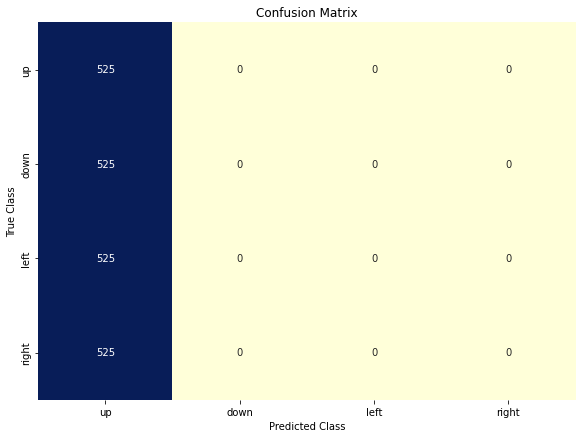

<Figure size 432x288 with 0 Axes>

In [ ]:
acc, stats = trainer.evaluate(
    show_confusion_matrix=True, 
    filestats_stdout=False, 
    logdir='/content/log'
)

In [ ]:
trainer.predict(
    file_or_folder = '/content/drive/MyDrive/DS/rotation_cls/pred_test', 
    batch_size=16, 
    print_results=True, 
    results_file='/content/log/tst.csv', 
    plot=True
)